# Active Learning for Sensor Selection in Composites Processing

References: 
- For stochastic modelling of the processing, the proposed bootstrap filtering model is used:\
    https://github.com/saniaki/stochastic_modelling

- The solver for generating data is a FEM model on thermochemical heat processing:\
    https://github.com/saniaki/FEM-heat

- For optimization, Scikit-Optimize, a sequential model-based optimization library in Python is used:\
    https://scikit-optimize.github.io/stable/ \
    https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html \
    https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt-gp-minimize

In [32]:
# import
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import scipy as sp
from scipy.stats import norm
from scipy import linalg
from ipywidgets import interactive
from IPython.display import clear_output
import timeit
%matplotlib inline

In [33]:
#set figure defaults for IPython notebook 
matplotlib.rcParams.update({'font.size': 18, 'lines.linewidth':4})

In [34]:
# Importing Bootstrap filter and FE models to this notebook:
# Bootstrap filter model available here is used to generate data for optimization:
# https://github.com/saniaki/stochastic_modelling
from ipynb.fs.full.FETemp import T_air, C, alpha_dot_func, alpha_func, Mesh, Mesh3, KCF, KCF3, Assemble, Assemble3
from ipynb.fs.full.FETemp import plot_Temp, plot_alpha, plot_temp_error_shade, plot_alpha_error_shade, plot_node_temp_std
from ipynb.fs.full.FETemp import FE
from ipynb.fs.full.Probabilistic_Modelling import plot_distribution
from ipynb.fs.full.Probabilistic_Modelling import Temp_bootstrap

In [35]:
from skopt import gp_minimize
from skopt.acquisition import gaussian_ei
from skopt.plots import plot_convergence
#np.random.seed(237)

#### A function for visualization of resutls

## Cost function

This model uses a cost function, a measure of our uncertanity, and optimizes that w.r.t to location of the sensor. We can target different goals in our optimization. Based on that, different costs (target to be minimized in our optimization) can be considered:
- summation of variance/std of all nodal temperatures at/up to given time tn (cost_sum_var/cost_sum_var_all)
- average of variance/std of all nodal temperatures at/up to given time tn (cost_ave_var/cost_ave_var_all)
- variance/std of temperatue at center at/up to given time tn
- variance/std of maximum nodal temperatures at/up to given time tn (cost_max_var_Tmax/cost_max_var_Tmax_all)
- variance/std of minimum nodal temperatures at/up to given time tn (cost_max_var_Tmin/cost_max_var_Tmin_all)
- ...

For example, we can find the best location to put our temperature sensor in order to have the least uncertainty for highest temperature that could occur during our composite processing (4th case in above list). Or, to have the least uncertainty for temperature at the center of composites part (it is obvious that the answer would be putting the censor at the center. But, this case could help when we have some constraints on the location of the sensor).



In [6]:
# cost at time tn
def Cost(T_var,T_mean, tn, typ):
    K = T_var.shape[0] # number of nodes
    cent_K = int(K/2) # centeric node
    
    # cost based on final temperature
    cost_sum_var = np.sum(T_var[:,tn-1], axis = 0)  # sum of std of all nodal temperature at time tn
    cost_ave_var = cost_sum_var/T_mean.shape[0] # avrage of std of all nodal temperature over at time tn
    Tmax_loc = np.argmax(T_mean[:,tn-1]) 
    cost_max_var_Tmax = T_var[Tmax_loc,tn-1] # std of maximum temperature at time tn
    Tmin_loc = np.argmin(T_mean[:,tn-1])
    cost_max_var_Tmin = T_var[Tmin_loc,tn-1] # std of minimum temperature at time tn
    cost_max_var_Tcent = T_var[cent_K+1,tn-1] # std of temperature at center of rod time tn
    
    # cost based on all temperatures
    cost_sum_var_all = np.sum(T_var[:,:tn-1])  # sum of std of all nodal temperature over all times (up to tn)
    cost_ave_var_all = np.average(T_var[:,:tn-1]) # avrage of std of all nodal temperature over all times (up to tn)
    Tmax_loc_all = np.unravel_index(np.argmax(T_mean[:,:tn-1]), np.array(T_mean[:,:tn-1]).shape) 
    cost_max_var_Tmax_all = T_var[Tmax_loc_all] # std of maximum temperature over all nodes and times
    Tmin_loc_all = np.unravel_index(np.argmin(T_mean[:,:tn-1]), np.array(T_mean[:,:tn-1]).shape) 
    cost_max_var_Tmin_all = T_var[Tmin_loc_all] # std of minimum temperature over all nodes and times
    cost_max_var_Tcent_all = np.sum(T_var[cent_K+1,:tn-1]) # std of temperature at center of rod over all times
    
    
    List_str = ['cost_sum_var', 'cost_ave_var', 'cost_max_var_Tmax', 'cost_max_var_Tmin', 'cost_max_var_Tcent',
                'cost_sum_var_all', 'cost_ave_var_all', 'cost_max_var_Tmax_all', 'cost_max_var_Tmin_all', 'cost_max_var_Tcent_all']
    
    List_num = [cost_sum_var, cost_ave_var, cost_max_var_Tmax, cost_max_var_Tmin, cost_max_var_Tcent,
                cost_sum_var_all, cost_ave_var_all, cost_max_var_Tmax_all, cost_max_var_Tmin_all, cost_max_var_Tcent_all]
    
    typ_loc = List_str.index(typ)
    
    return List_num[typ_loc]
    

In [7]:
# The function targeted in optimization
def f(x):
    num_t = int((t_end-t_start)/delt)
    
    T_mean, T_var, Coords, \
    alpha_mean, alpha_var, alpha_dot_mean, \
    alpha_dot_var = Temp_bootstrap(sensor_loc_typ,x,obs_sigma,T_sigma,alpha_sigma,alpha_dot_sigma,
                                        muT_sigma,mualpha_sigma,mualpha_dot_sigma,
                                        N,t_start,t_end,delt,Length_c,Length_t,num_el_c,num_el_t,
                                        Coords_start,air_temp_type,T_start,T_hold,T_const,T_rate,th1,th2,
                                        T_air_sigma,
                                        material_dict,Analysis,cri,
                                        Element_type,heat_gen,T_true,alpha_true,alpha_dot_true)
    
    cst = Cost(T_var,T_mean, num_t, typ)/1e3
    print('Tried point {}. Cost value = {}'.format(x, cst))
    print('Loading... ')
    return  cst 

## Example: Two available sensor

### Inputs
Material properties

In [8]:
# material properties, mean values
rho_c_mean = 1463 # composites density (kg/m3) 
# --> 1463 for AS4/3501-6 composites (https://pdfs.semanticscholar.org/f069/9fb46a1958f250cc748a673e5a6b8e1910c6.pdf)
#--> 1790 for AS4 carbon (https://www.900gpa.com/en/product/fiber/CF_001EF245BC?u=metric)
k_c_mean = 0.65 # composites thermal conductivity (W/m K) 
# --> 0.65 for AS4/3501-6 composites (https://pdfs.semanticscholar.org/f069/9fb46a1958f250cc748a673e5a6b8e1910c6.pdf)
#--> 6.83 for AS4 carbon (https://www.900gpa.com/en/product/fiber/CF_001EF245BC?u=metric)
Cp_c_mean = 1200 # composite specific heat capacity (J/kg K) 
# --> 1200 for AS4/3501-6 composites (https://pdfs.semanticscholar.org/f069/9fb46a1958f250cc748a673e5a6b8e1910c6.pdf)
# --> 1300 for AS4 Carbon (https://www.researchgate.net/figure/Specific-heat-capacity-of-AS4-carbon-fiber-PES-matrix-and-CF-PES-tape-fiber-volume_fig6_320801788)
rho_r_mean = 1256 # resin density  (kg/m3), 
# -->1256 for 3501-6 (https://www.researchgate.net/figure/3-Properties-of-Hexcel-3501-6-Epoxy-Resin-17_tbl3_267585693)
H_r_mean = 400e3 # resin heat of reasction per unit mass (J / kg)
# --> 400*1000  for 3501-6 (https://books.google.ca/books?id=p__RBQAAQBAJ&pg=PA478&lpg=PA478&dq=resin+3501-6+heat+reaction+per+unit+mass&source=bl&ots=yzGE-Cu-Fo&sig=ACfU3U07FEurjhNeAVzwOKofNp-Y_zYDdw&hl=en&sa=X&ved=2ahUKEwjut6Lx2OboAhUMrp4KHf90BkAQ6AEwAHoECAsQLA#v=onepage&q=resin%203501-6%20heat%20reaction%20per%20unit%20mass&f=false)
nu_r_mean = 0.33 # resin volume fraction in composite material 
# --> 0.33
h_c_mean = 120; # convection heat trasnfer coefficient (W/ m2 K)
# --> 120 in autoclave (https://www.semanticscholar.org/paper/HEAT-TRANSFER-COEFFICIENT-DISTRIBUTION-INSIDE-AN-Slesinger-Shimizu/b61dfa6b4811edb51b003e43cc61088f0d13e348)

# tool properties
rho_t_mean = 8150; # tool density (kg/m3) 
# -->  ~ 8150 for Invar (https://www.azom.com/properties.aspx?ArticleID=515)
k_t_mean = 13; # tool thermal conductivity (W/m K) 
# --> ~13 for Invar (https://www.azom.com/properties.aspx?ArticleID=515)
Cp_t_mean = 510; # tool specific heat capacity (J/kg K) 
# --> ~ 510 for Invar (https://www.azom.com/properties.aspx?ArticleID=515)
h_t_mean = 100;

# cure kenetic
# Table 5.2 of S. Amini Niaki thesis for 3501-6
A1_mean = 3.5017e7
A2_mean = -3.3567e7
A3_mean = 3.2667e3
dE1_mean = 80700
dE2_mean = 77800
dE3_mean = 56600
# Table 5.2 of S.A. Niaki thesis for 3501-6  
BB_mean = 0.47

Geometry

In [9]:
# geometry
# composite
Length_c = 0.030 # rod length (m)
num_el_c = 10 # number of elements
# tool
Length_t = 0.015 # tool length (m)
num_el_t = 5 # number of elements
Coords_start = 0 # first node x coordinate

Air and initial temperature

In [10]:
# air temperautre
air_temp_type = 'OneHold' # 'Constant', 'ConstantRate', 'OneHold'
T_start = 20+273 # start air temperature (K)
T_const = 180+273 # air consat temperate (for 'Constat' type) (K)
T_rate = 0.5 # air temperature increase rate (for 'Constant_rate' type)
T_hold = 170+273 # air hold temperate (for 'OneHold' type) (K)
th1 = 70*60 # time for start of hold (for 'OneHold' type) (seconds)
th2 = 170*60 # time for end of hold (for 'OneHold' type) (seconds)

num_el = num_el_c + num_el_t
T_ini = np.ones((num_el+1,1))* T_air(0,air_temp_type,T_start,
                                     T_hold,T_const,T_rate,th1,th2,T_air_sigma = 0) # initital temperature of material

alpha_ini = np.zeros((num_el,1))
alpha_dot_ini = np.zeros((num_el,1))


num_el = num_el_c + num_el_t
T_ini = np.ones((num_el+1,1))* T_air(0,air_temp_type,T_start,
                                     T_hold,T_const,T_rate,th1,th2,T_air_sigma = 0) # initital temperature of material


alpha_ini = np.zeros((num_el,1))
alpha_dot_ini = np.zeros((num_el,1))

Time 

In [11]:
t_start = 0 # start time (seconds)
t_end = 40*60 # end time (seconds)
delt = 1 # time step (seconds)
n = int(int(t_end-t_start)/delt + 1) # number of states

Analysis type

In [12]:
# analysis type
Analysis = 'Forward';  # 'Backward' or 'Forward', Backward is Implicit Euler w/ Newton Raphson, Forward is Expicit Euler
cri = 0.01 # convergence criteria value for Implicit analysis
Element_type = 'Linear' # 'Linear' or 'Nonlinear'

# heat generation switch
heat_gen = 'Yes' # 'Yes' or 'No'

Optimization details

In [13]:
typ = 'cost_sum_var_all'
number_of_sensors = 2

sensor_loc_typ = 'node'
bounds = [(1,num_el+1)] * number_of_sensors # whole area, a list of tuples
bounds = [(6,16), (6,16)]
#sensor_loc_typ = 'loc'
#bounds = [(0,Length_t + Length_c)] * number_of_sensors # whole area, a list of tuples


acq_func = "EI"
n_calls = 15
#noise = "guassian"
n_random_starts= 4

Uncertainty values in input parameters 

In [15]:
# probabilistic modelling input parameters
N = 100 # number of samples

# uncertainty in measurements of temperature
obs_sigma = 1
# deterministc solutions uncertainties
T_sigma = 0
muT_sigma = 0
alpha_sigma = 0
mualpha_sigma = 0
alpha_dot_sigma = 0
mualpha_dot_sigma = 0
# uncertainties in material properties
rho_c_sigma = 3*2
k_c_sigma = 0.05*2
Cp_c_sigma = 10*2
rho_r_sigma = 6*2
H_r_sigma = 1000*2
nu_r_sigma = 0.01*2
h_c_sigma = 2*2
rho_t_sigma = 3*2
k_t_sigma = 0.05*2
Cp_t_sigma = 10*2
h_t_sigma = 2*2
A1_sigma = 0.5e7*2
A2_sigma = 0.3e7*2
A3_sigma = 0.10e3*2
dE1_sigma = 50*2
dE2_sigma = 50*2
dE3_sigma = 50*2
BB_sigma = 0.01*2
# uncertainty in air temperature
T_air_sigma = 0

a_c_mean =  k_c_mean/(rho_c_mean*Cp_c_mean)
b_c_mean =  rho_r_mean*H_r_mean*nu_r_mean/(rho_c_mean*Cp_c_mean)
Ch_c_mean = h_c_mean/k_c_mean*a_c_mean; 

a_t_mean =  k_t_mean/(rho_t_mean*Cp_t_mean);
b_t_mean =  0;
Ch_t_mean = h_t_mean/k_t_mean*a_t_mean;

material_dict = {'k_c_mean':k_c_mean,'k_c_sigma':k_c_sigma,
                 'rho_c_mean':rho_c_mean,'rho_c_sigma':rho_c_sigma,
                 'Cp_c_mean':Cp_c_mean,'Cp_c_sigma':Cp_c_sigma,
                 'rho_r_mean':rho_r_mean,'rho_r_sigma':rho_r_sigma,
                 'H_r_mean':H_r_mean,'H_r_sigma':H_r_sigma,
                 'nu_r_mean':nu_r_mean,'nu_r_sigma':nu_r_sigma,
                 'h_c_mean':h_c_mean,'h_c_sigma':h_c_sigma,
                 'k_t_mean':k_t_mean,'k_t_sigma':k_t_sigma,
                 'rho_t_mean':rho_t_mean,'rho_t_sigma':rho_t_sigma,
                 'Cp_t_mean':Cp_t_mean,'Cp_t_sigma':Cp_t_sigma,
                 'h_t_mean':h_c_mean,'h_t_sigma':h_c_sigma,
                 'A1_mean':A1_mean,'A1_sigma':A1_sigma,
                 'A2_mean':A2_mean,'A2_sigma':A2_sigma,
                 'A3_mean':A3_mean,'A3_sigma':A3_sigma,
                 'dE1_mean':dE1_mean,'dE1_sigma':dE1_sigma,
                 'dE2_mean':dE2_mean,'dE2_sigma':dE2_sigma,
                 'dE3_mean':dE3_mean,'dE3_sigma':dE3_sigma,
                 'BB_mean':BB_mean,'BB_sigma':BB_sigma,}

Generating synthetic observation data

In [16]:
# Generating fake observation data
# true temperature
start = timeit.default_timer()

T_true, Coords, alpha_true, alpha_dot_true, = FE(t_start,t_end,delt,Length_c,Length_t,num_el_c,num_el_t,
                                                 Coords_start,air_temp_type,
                                                 T_start,T_hold,T_const,T_rate,th1,th2,0,
                                                 a_c_mean,b_c_mean,Ch_c_mean,a_t_mean,b_t_mean,Ch_t_mean,
                                                 BB_mean,A1_mean,A2_mean,A3_mean,dE1_mean,dE2_mean,dE3_mean,
                                                 Analysis,cri,Element_type,heat_gen,T_ini,alpha_ini,alpha_dot_ini)
# obervations
# fake observations are generated whiting Temp_bootstrap function. In case observation are to be given
# by user, this function should be modified accordingly. 

stop = timeit.default_timer()
print('Run time (s): ', stop - start)

Run time (s):  3.2201082999999997


### Optimization

In [22]:
opt = gp_minimize(f,                  # the function to minimize
                  bounds,      # the bounds on each dimension of x 
                  acq_func=acq_func,      # the acquisition function
                  n_calls=n_calls,         # the number of evaluations of f
                  n_random_starts=n_random_starts,  # the number of random initialization points
                  noise="gaussian",       # the noise level (optional)
                  random_state=None) 
print('DONE')

progress is : 99.8%
Tried point [6, 11]. Cost value = 1.6415204870394513
Loading... 
DONE


### Results

All sampled locations during optimization

In [23]:
# all iterations (if duplication is allowed)
# opt.x_iters
#opt.func_vals
print("All x iterations are:\n",opt.x_iters)
print("\n All function values are:\n", opt.func_vals)

All x iterations are:
 [[9, 10], [11, 10], [16, 7], [15, 12], [16, 11], [16, 16], [6, 11], [6, 11], [6, 11], [6, 6], [6, 11], [6, 12], [6, 11], [6, 11], [6, 11]]

 All function values are:
 [ 5.01086589  4.75336232 12.80703936  6.66386643  4.79942124 30.15436987
  2.30540994  1.81279713  2.58072202 13.32575062  1.29761158  3.60347365
  1.73356032  2.17095166  1.64152049]


In [24]:
# removing the duplicates sensor locations (sensors cannot be at same nodes)
xiterations = list.copy(opt.x_iters)
funcvals = list.copy(list(opt.func_vals))
index = 0
for i in opt.x_iters:
    if len(i) != len(set(i)):
        xiterations.pop(index)
        funcvals.pop(index)
        index -=1
    index += 1
# all iterations (if duplication is not allowed)
print("All x iterations are (sensors are not at same location):\n",xiterations)
print("\n All function values are:\n", funcvals)

All x iterations are (sensors are not at same location):
 [[9, 10], [11, 10], [16, 7], [15, 12], [16, 11], [6, 11], [6, 11], [6, 11], [6, 11], [6, 12], [6, 11], [6, 11], [6, 11]]

 All function values are:
 [5.01086589190201, 4.753362322963669, 12.80703935525049, 6.663866425143477, 4.799421235898167, 2.305409935040382, 1.8127971312500968, 2.5807220220355895, 1.297611578483224, 3.603473650131531, 1.7335603227330854, 2.1709516610518813, 1.6415204870394513]


best sensor location(s)

In [25]:
# optimum results (if duplications is allowed)
#"x1^*=%.4f, x2^*=%.4f, f=%.4f" % (opt.x[0], opt.x[1], opt.fun)
print(opt.x)
print(opt.fun)

[6, 11]
1.297611578483224


In [26]:
# optimum results (if duplications is not allowed)
#"x1^*=%.4f,  x2^*=%.4f, f=%.4f" % (result[0], result[1], funcvals[np.argmin(funcvals)])
result = xiterations[np.argmin(funcvals)]
print(result)
print(funcvals[np.argmin(funcvals)])

[6, 11]
1.297611578483224


Convergence plot

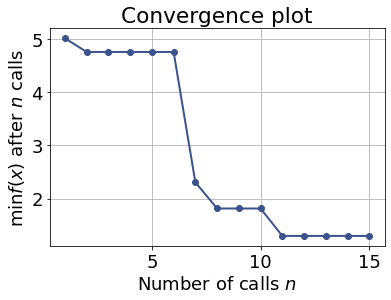

In [36]:
plot_convergence(opt)

Values of target function for all iterations

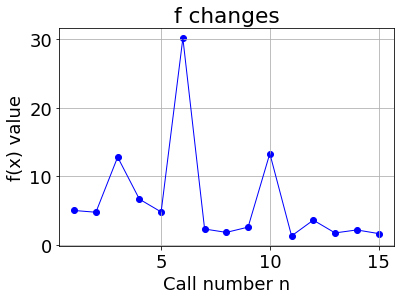

In [37]:
plt.scatter([*range(1,n_calls+1)], list(opt.func_vals), color = 'blue')
plt.plot([*range(1,n_calls+1)],opt.func_vals, linewidth=1, color = 'blue')
plt.title('f changes')
plt.xlabel('Call number n')
plt.ylabel('f(x) value')
plt.grid()
plt.show()

Running probilistic model with optimum sensor locations

In [38]:
sensor_loc_n = result
sensor_loc = [(i-1) * (Length_t+Length_t) / (num_el_t+num_el_c) for i in sensor_loc_n] 

T_mean_test, T_var_test, Coords_test, \
alpha_mean_test, alpha_var_test, alpha_dot_mean_test, \
alpha_dot_var_test = Temp_bootstrap(sensor_loc_typ,sensor_loc_n,obs_sigma,T_sigma,alpha_sigma,alpha_dot_sigma,
                                    muT_sigma,mualpha_sigma,mualpha_dot_sigma,
                                    N,t_start,t_end,delt,Length_c,Length_t,num_el_c,num_el_t,
                                    Coords_start,air_temp_type,T_start,T_hold,T_const,T_rate,th1,th2,T_air_sigma,
                                    material_dict,Analysis,cri,
                                    Element_type,heat_gen,T_true,alpha_true,alpha_dot_true)

progress is : 99.8%


Temperature and uncertainity predictions for best location of sensors

In [41]:
interactive(lambda t=0: plot_temp_error_shade(t,t_start,t_end,delt,Coords_test,T_mean_test,T_var_test*50,air_temp_type,
                                              T_start,T_hold,T_const,T_rate,th1,th2,T_air_sigma,T_ini,
                                              sensor_loc_typ,sensor_loc_n,Length_c,Length_t,num_el_c,num_el_t),
            t=(t_start,t_end,(t_end-t_start)/20))

interactive(children=(FloatSlider(value=0.0, description='t', max=2400.0, step=120.0), Output()), _dom_classes…